In [10]:
import numpy as np
import seaborn as sns
import nfl_data_py as nfl
import matplotlib.pyplot as plt

In [11]:
COLS_AND_WEIGHTS = {
    'non_fantasy_stats': {
        'completions': {
            'dist_type': 'poisson',
        }, 
        'attempts': {
            'dist_type': 'poisson',
        },
        'targets': {
            'dist_type': 'poisson',
        }, 
        'passing_first_downs': {
            'dist_type': 'poisson',
        },  
        'passing_epa': {
            'dist_type': 'normal',
        }, 
        'carries': {
            'dist_type': 'poisson',
        }, 
        'rushing_epa': {
            'dist_type': 'normal',
        }, 
        'rushing_first_downs': {
            'dist_type': 'poisson',
        }, 
        'receiving_first_downs': {
            'dist_type': 'poisson',
        }, 
        'receiving_epa': {
            'dist_type': 'normal',
        }, 
    },
    'fantasy_stats': {
        'passing_yards': {
            'dist_type': 'normal',
            'weight': 0.04,
        },
        'passing_tds': {
            'dist_type': 'poisson',
            'weight': 4,
        },
        'interceptions': {
            'dist_type': 'poisson',
            'weight': -2,
        },
        'sack_fumbles_lost': {
            'dist_type': 'poisson',
            'weight': -2,
        },
        'rushing_fumbles_lost': {
            'dist_type': 'poisson',
            'weight': -2,
        },
        'receiving_fumbles_lost': {
            'dist_type': 'poisson',
            'weight': -2,
        },
        'passing_2pt_conversions': {
            'dist_type': 'poisson',
            'weight': 2,
        },
        'rushing_2pt_conversions': {
            'dist_type': 'poisson',
            'weight': 2,
        },
        'receiving_2pt_conversions': {
            'dist_type': 'poisson',
            'weight': 2,
        },
        'rushing_yards': {
            'dist_type': 'normal',
            'weight': 0.1,
        },
        'rushing_tds': {
            'dist_type': 'poisson',
            'weight': 6,
        },
        'receptions': {
            'dist_type': 'poisson',
            'weight': 1,
        },
        'receiving_yards': {
            'dist_type': 'normal',
            'weight': 0.1,
        },
        'receiving_tds': {
            'dist_type': 'poisson',
            'weight': 6,
        },
        'special_teams_tds': {
            'dist_type': 'poisson',
            'weight': 6,
        },
    },
}

In [12]:
def run_simulation(data, n_iter=10000):
    fantasy_stats = COLS_AND_WEIGHTS['fantasy_stats']
    non_fantasy_stats = COLS_AND_WEIGHTS['non_fantasy_stats']

    all_stats = {**fantasy_stats, **non_fantasy_stats}
    final_data = {}
    for i in range(n_iter):
        score = 0
        final_data[f'sim_{i}'] = {}
        for stat in all_stats:
            data_mean = data[stat].mean()
            data_std = data[stat].std()
            if all_stats[stat]['dist_type'] == 'poisson':
                rand_var = np.random.poisson(lam=data_mean)
            elif all_stats[stat]['dist_type'] == 'normal':
                rand_var = np.random.normal(loc=data_mean, scale=data_std)
            
            if stat in fantasy_stats:
                score += rand_var * fantasy_stats[stat]['weight']

            final_data[f'sim_{i}'][stat] = rand_var
        
        final_data[f'sim_{i}']['fantasy_points'] = score

    return final_data

In [13]:
def summarize(data):
    f_points = np.array([data[k]['fantasy_points'] for k in data])
    mean_f_points = np.mean(f_points)
    median_f_points = np.median(f_points)
    std_dev = np.std(f_points)
    percentile_5 = np.percentile(f_points, 10)
    percentile_95 = np.percentile(f_points, 90)

    return f_points, mean_f_points, median_f_points, std_dev, percentile_5, percentile_95

In [14]:
def histogram(f_points, mean_points, median_points, floor, ceiling):
    plt.hist(f_points, bins=30, color='skyblue', edgecolor='black')
    plt.axvline(mean_points, color='red', linestyle='dashed', linewidth='1', label=f'Mean: {mean_points:.2f}')
    plt.axvline(median_points, color='green', linestyle='dashed', linewidth='1', label=f'Median: {median_points:.2f}')
    plt.axvline(floor, color='orange', linestyle='dashed', linewidth='1', label=f'Floor: {floor:.2f}')
    plt.axvline(ceiling, color='purple', linestyle='dashed', linewidth='1', label=f'Ceiling: {ceiling:.2f}')
    plt.title('Distribution of Fantasy Points')
    plt.xlabel('Fantasy Points')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [15]:
def cdf(f_points):
    sorted_points = np.sort(f_points)
    cdf = np.arange(len(sorted_points)) / float(len(sorted_points))
    plt.plot(sorted_points, cdf, color='blue')
    plt.title('Cumulative Distribution Function of Fantasy Points')
    plt.xlabel('Fantasy Points')
    plt.ylabel('Cumulative Probability')
    plt.grid(True)
    plt.show()

In [16]:
def boxplot(f_points):
    plt.boxplot(f_points, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title('Box Plot of Fantasy Points')
    plt.xlabel('Fantasy Points')
    plt.show()


In [17]:
def kde_plot(f_points, mean_points, median_points, floor, ceiling):
    sns.kdeplot(f_points, fill=True, color='skyblue')
    plt.title('Density Plot of Fantasy Points')
    plt.xlabel('Fantasy Points')
    plt.ylabel('Density')
    plt.axvline(mean_points, color='red', linestyle='dashed', linewidth='1', label=f'Mean: {mean_points:.2f}')
    plt.axvline(median_points, color='green', linestyle='dashed', linewidth='1', label=f'Median: {median_points:.2f}')
    plt.axvline(floor, color='orange', linestyle='dashed', linewidth='1', label=f'Floor: {floor:.2f}')
    plt.axvline(ceiling, color='purple', linestyle='dashed', linewidth='1', label=f'Ceiling: {ceiling:.2f}')
    plt.legend()
    plt.show()

In [18]:
## PLAYER COMPS
def expected_vs_risk(f_points, mean_points, p_name):
    std_dev = np.std(f_points)
    print(f"Std Dev: {std_dev}")
    plt.scatter(mean_points, std_dev, color='blue', label=p_name)
    plt.title('Mean Fantasy Points vs. Risk (Standard Deviation')
    plt.xlabel('Mean Fantasy Points')
    plt.ylabel('Standard Deviation (Risk)')
    plt.grid(True)
    plt.legend()
    plt.show()


In [46]:
weekly_data = nfl.import_weekly_data(years=[2023, 2024])

Downcasting floats.


In [47]:
player_name = "Jayden Daniels"

In [48]:
player_data = weekly_data[weekly_data["player_display_name"] == player_name]

In [49]:
player_data

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
305,00-0039910,J.Daniels,Jayden Daniels,QB,QB,None,WAS,2024,1,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,28.16,28.16


In [26]:
len(player_data)

0

In [482]:
sim_data = run_simulation(player_data)

In [483]:
fantasy_points, mean_fantasy_points, median_fantasy_points, std_dev, percentile_5, percentile_95 = summarize(sim_data)

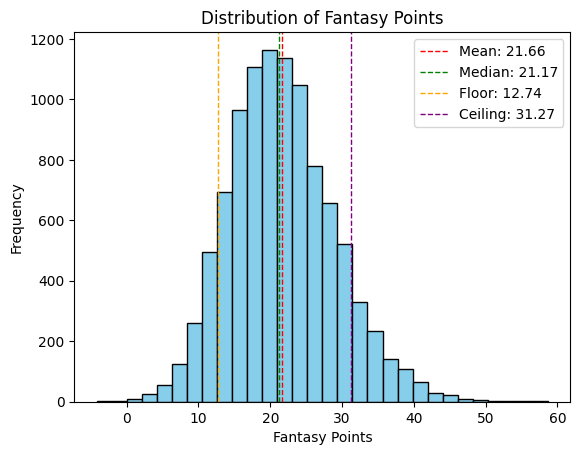

In [484]:
histogram(fantasy_points, mean_fantasy_points, median_fantasy_points, percentile_5, percentile_95)

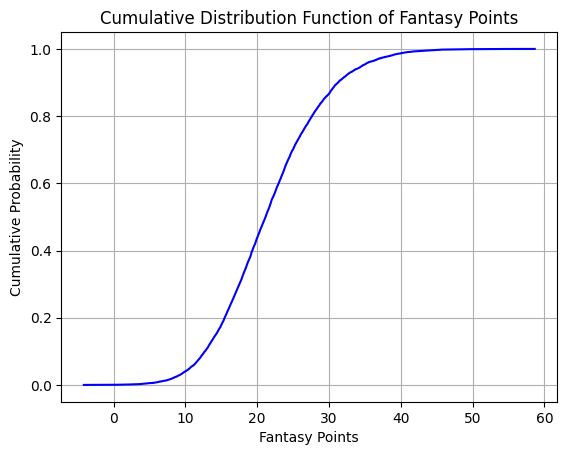

In [485]:
cdf(fantasy_points)

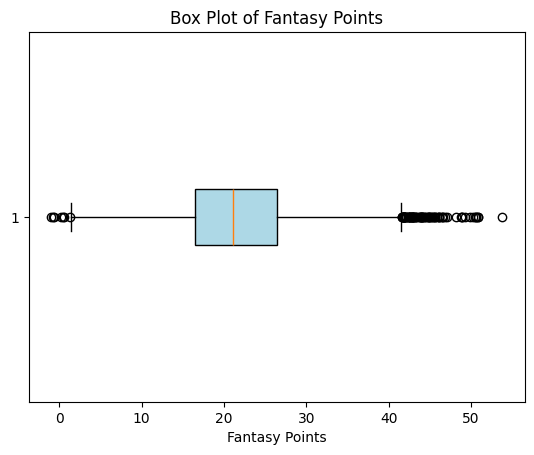

In [471]:
boxplot(fantasy_points)

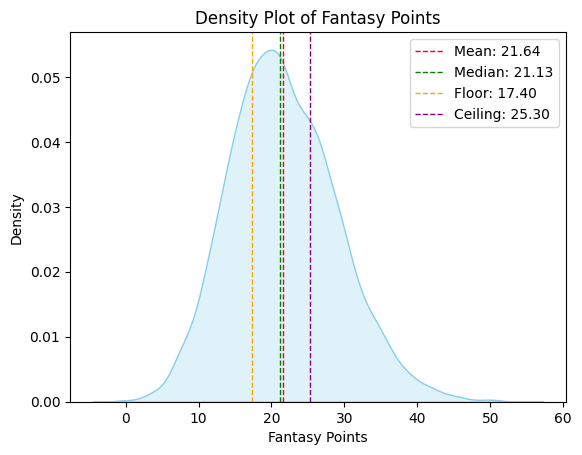

In [472]:
kde_plot(fantasy_points, mean_fantasy_points, median_fantasy_points, percentile_5, percentile_95)

Std Dev: 4.850854165197181


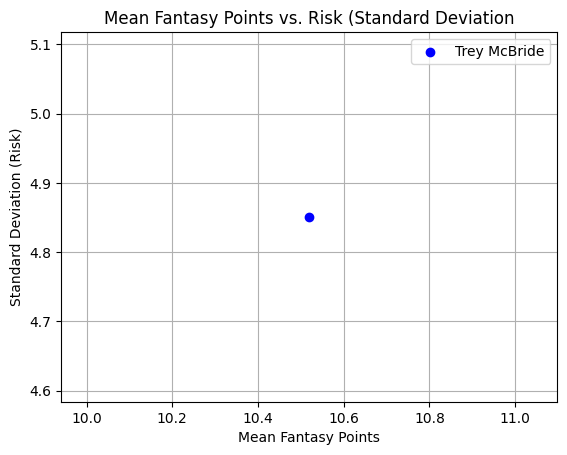

In [408]:
expected_vs_risk(fantasy_points, mean_fantasy_points, player_name)